## 5 Year Revenue Stats Predictions

In [1]:
from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error, r2_score
from sktime.utils.plotting import plot_series
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.fbprophet import Prophet
import sys
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
sys.path.append("..")

In [2]:
# Bring in the Data
Revenue = pd.read_excel(r"C:\Users\HENRY OKEOMA\Desktop\company revenue stats 5yrs.xlsx", parse_dates=[0], index_col=[0])

In [3]:
# Create a copy of the Dataframe
df1 = Revenue.copy()

In [4]:
df1.head()

,Month,Revenue (GBP)
Year,,
2018-01-01,January,95000
2018-02-01,February,110000
2018-03-01,March,160000
2018-04-01,April,175000
2018-05-01,May,150000


In [5]:
# We have to drop the month as we dont require this
column_to_drop = 'Month'
df1 = df1.drop(column_to_drop, axis=1)
df1.head(2)

,Revenue (GBP)
Year,
2018-01-01,95000
2018-02-01,110000


0.5413553905364692
0.5363246187786044


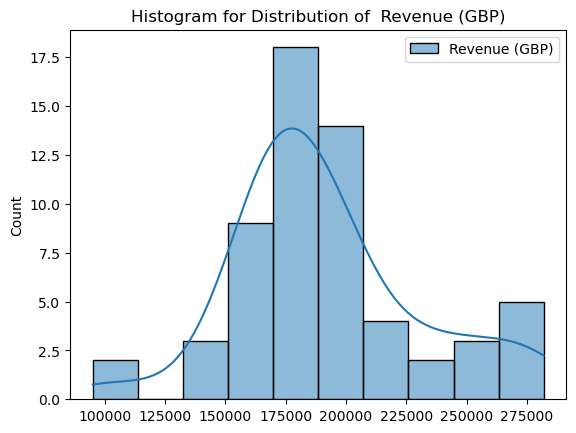

In [8]:
# Understanding our data to see the distribution of the revenue
sns.histplot(df1, kde=True, bins=10)
plt.title('Histogram for Distribution of  Revenue (GBP)')
print(df1['Revenue (GBP)'].skew())
print(df1['Revenue (GBP)'].kurtosis());

### Skewness, positively skewed, nearly symetrical. Kurtosis of 0.5, almost no outliers

<Figure size 2000x500 with 0 Axes>

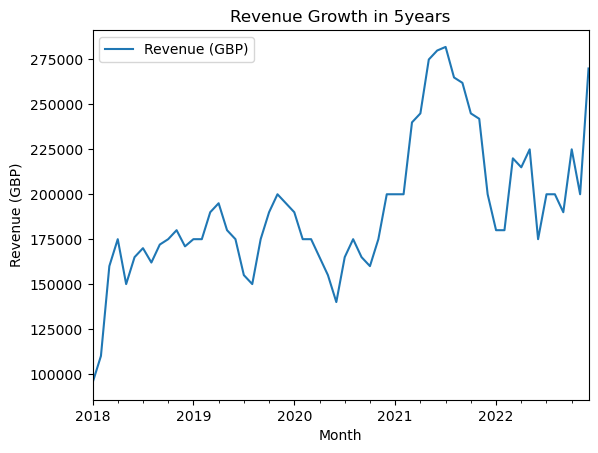

In [9]:
# Lets have a quick plot to see the Trend and seasonality on our revenue
plt.figure(figsize=(20,5))
df1.plot()
plt.title('Revenue Growth in 5years')
plt.xlabel('Month')
plt.ylabel('Revenue (GBP)')
plt.show();

### An upward trend of revenue.

In [10]:
# We create a frequency to be between Months 'M' 
df2 = df1.resample(rule='M').sum() 

In [11]:
# Use our Facebook Prophet Algorithm to make our forecast
forecaster = Prophet()

In [12]:
# We set out horizon to split at tail for 20 months 
horizon = 20

In [14]:
# Train the data up on till where we termed the Horizon
y_train = df1[:-horizon]
y_test = df1.tail(horizon)

In [15]:
# Fit our data to the model  Training
forecaster.fit(y_train)

01:42:45 - cmdstanpy - INFO - Chain [1] start processing
01:42:46 - cmdstanpy - INFO - Chain [1] done processing


Prophet()

In [16]:
fh = ForecastingHorizon(y_test.index, is_relative=False)

In [17]:
y_pred = forecaster.predict(fh)
y_pred.head(3)

,Revenue (GBP)
2021-05-01,186646.224320
2021-06-01,182182.952286
2021-07-01,195212.313818


In [18]:
# Set confidence Interval at 90%
ci = forecaster.predict_interval(fh, coverage=0.9)
ci.head(3)

Coverage               
                      0.9               
                    lower          upper
2021-05-01  157327.855639  217132.963170
2021-06-01  152537.561800  211350.624307
2021-07-01  165266.948610  223859.439444

### This sets the upper and lower intervals on the predicted values

In [19]:
# Call the original observations and assign as y_true
y_true = df1.tail(horizon)
y_true.head(3)

,Revenue (GBP)
Year,
2021-05-01,275000
2021-06-01,280000
2021-07-01,282000


In [24]:
# Calculate the metrics and compare with predicted and original
mae = mean_absolute_error(y_true, y_pred)

print('MAE:', round(mae,1))


MAE: 35801.5


### we have a mean absolute error of approx 36k per month

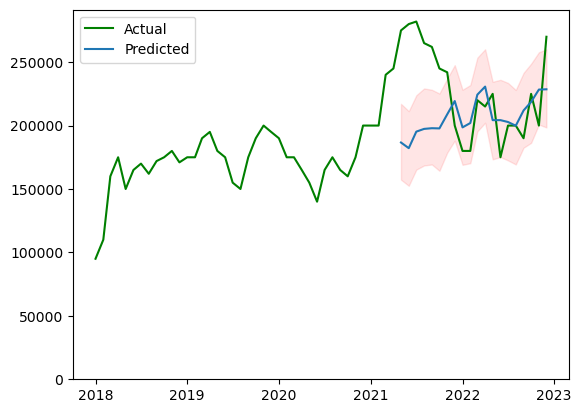

In [25]:
# Lets visualise with a plot
plt. plot(df1.tail(horizon * 3), label = 'Actual', color='green')

plt.gca().fill_between(ci.index, (ci.iloc[:, 0]), (ci.iloc[:, 1]), color='r', alpha=0.1)

plt.plot(y_pred, label='Predicted')
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.show()

### We have made predictions with data known to us and also see how our model is performing, now next will be to make forecast into the future

In [26]:
# Predict into the future with no Train test Split
forecaster = Prophet()
forecaster.fit(df2)

last_date = df2.index.max()
fh = ForecastingHorizon(pd.date_range(str(last_date), periods=horizon, freq='M'), is_relative=False)

y_pred = forecaster.predict(fh)
ci = forecaster.predict_interval(fh, coverage=0.9).astype('float')

01:50:12 - cmdstanpy - INFO - Chain [1] start processing
01:50:12 - cmdstanpy - INFO - Chain [1] done processing


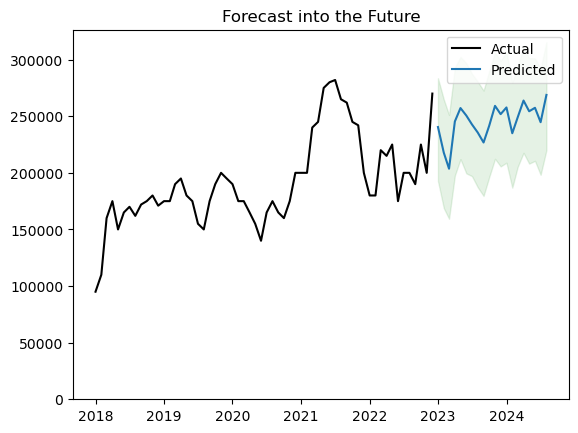

In [27]:
# Lets visualise with a plot further with Future outlook
plt. plot(df1.tail(horizon * 3), label = 'Actual', color='black')

plt.gca().fill_between(ci.index, (ci.iloc[:, 0]), (ci.iloc[:, 1]), color='g', alpha=0.1)

plt.plot(y_pred, label='Predicted')
plt.title('Forecast into the Future')
plt.ylim(bottom=0)
plt.legend()
plt.show()
plt.show()


### We have not predicted to our future in our dataset using the historic data of 5years setting our confidence interval still at 90%


## We want to Create a Function to make predictions on each ocassion for Validation=True or False. 

### False when predicting into the Future
### True when splitting for verifications

In [28]:
# Define a function to make predictions

def sktime_forecast(dataset, horizon, forecaster, validation=False, confidence=0.9, frequency='M'):
    #adjust frequency
    df2 = dataset.resample(rule=frequency).sum()
    
    #interpolate missing periods (if any)
    df2 = df2.interpolate(method='time')
    for col in dataset.columns:
     # Use train/test split to validate forecaster
        if validation:
            df1 = df2[col]
            
            y_train = df1[:-horizon]
            y_test = df1.tail(horizon)
            
            forecaster.fit(y_train)
            fh = ForecastingHorizon(y_test.index, is_relative=False)
            y_pred = forecaster.predict(fh)
            ci = forecaster.predict_interval(fh, coverage=confidence).astype('float')
            y_true = df1.tail(horizon)
            
            mae = mean_absolute_error(y_true, y_pred)
            
             # Make predictions beyond the dataset
        if not validation:
            df1 = df2[col].dropna()
            forecaster.fit(df1)

            last_date = df1.index.max()
            fh = ForecastingHorizon(
                pd.date_range(str(last_date), periods=horizon, freq=frequency),
                is_relative=False,
            )

            y_pred = forecaster.predict(fh)
            ci = forecaster.predict_interval(fh, coverage=confidence).astype("float")
            mae = np.nan
        # Visualize results
        plt.plot(
            df1.tail(horizon * 3),
            label="Actual",
            color="black",
        )
        plt.gca().fill_between(
            ci.index, (ci.iloc[:, 0]), (ci.iloc[:, 1]), color="b", alpha=0.1
        )
        plt.plot(y_pred, label="Predicted")
        plt.title(f"{horizon} Months forecast {col} (mae: {round(mae, 2)}, confidence: {confidence*100}%)")
        plt.ylim(bottom=0)
        # plt.legend()
        plt.grid(False)
        plt.show()

In [29]:
forecaster = Prophet(yearly_seasonality=True)

01:55:00 - cmdstanpy - INFO - Chain [1] start processing
01:55:00 - cmdstanpy - INFO - Chain [1] done processing


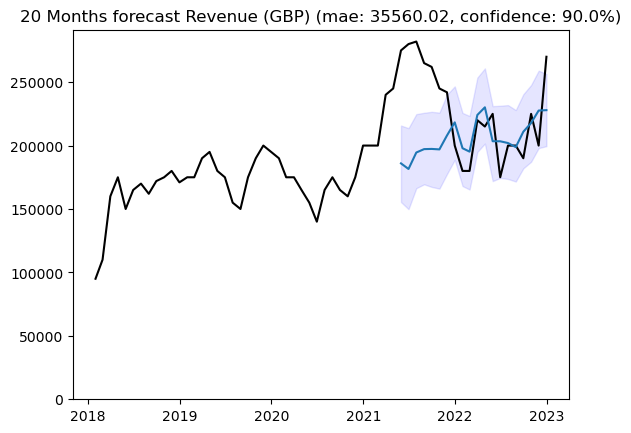

In [30]:
sktime_forecast(dataset=df2, horizon=20, forecaster=forecaster, validation=True)

01:55:11 - cmdstanpy - INFO - Chain [1] start processing
01:55:11 - cmdstanpy - INFO - Chain [1] done processing


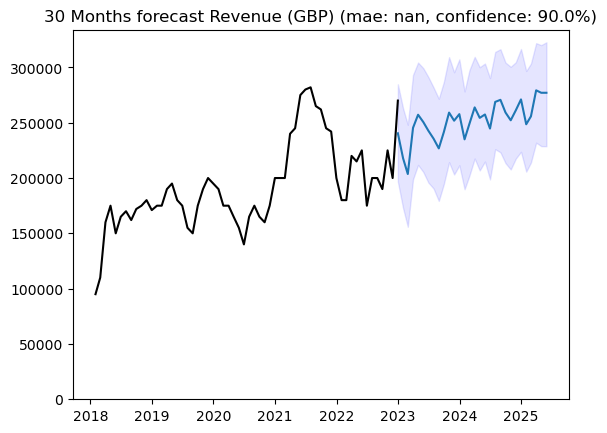

In [31]:
sktime_forecast(dataset=df2, horizon=30, forecaster=forecaster, validation=False)

### We have successfully created a Function with validation parameters. if set to False, it makes predictions into the future, but if set to True, it makes predictions using the train test split and calculates the error metrics